## Import libraries

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import monai
from monai.data import Dataset, ArrayDataset, DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, CropForegroundd, ScaleIntensityRangePercentilesd, Resized

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# reload if update
import importlib
import util
importlib.reload(util)

<module 'util' from '/home/xavier/IMA206_project/util.py'>

## Load data and visualize

/home/xavier/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


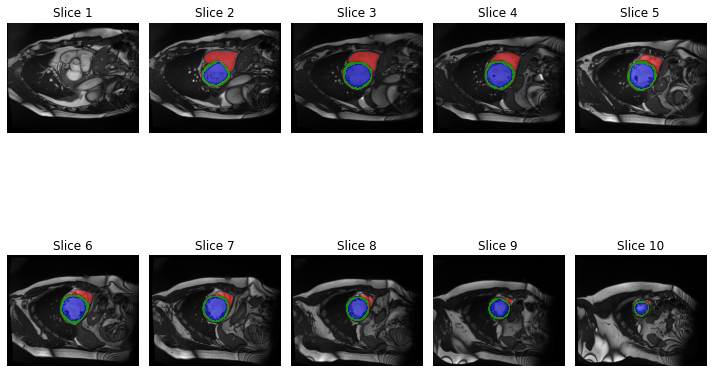

In [3]:
# visualize raw example before preprocessing
file_dict1 = util.load_file_dict(1,'ED')
data_dict1 = util.load_data_dict(1,'ED')
util.visualize_3D(data_dict1)

In [4]:
train_dicts = []
for patient_id in range(1,101):
    train_dicts.append(util.load_file_dict(patient_id,'ED'))
    train_dicts.append(util.load_file_dict(patient_id,'ES'))

test_dicts = []
for patient_id in range(101,151):
    test_dicts.append(util.load_file_dict(patient_id,'ED'))
    test_dicts.append(util.load_file_dict(patient_id,'ES'))

len(train_dicts), len(test_dicts)

(200, 100)

In [5]:
train_dicts[0]

{'image': './database/training/patient001/patient001_frame01.nii.gz',
 'label': './database/training/patient001/patient001_frame01_gt.nii.gz'}

## Preprocessing

In [6]:
class CropForegroundSquared:
    '''
    crop input using bounding box with flex margin such that output is square
    '''
    def __init__(self, keys, source_key, min_margin):
        self.keys = keys
        self.source_key = source_key
        self.min_margin = min_margin

    def __call__(self, img_dict):
        mask = img_dict[self.source_key] > 0
        idx = torch.argwhere(mask)
        mins,_ = idx.min(dim=0)
        maxs,_ = idx.max(dim=0)
        _, a, b, _ = maxs - mins
        z_s = mins[3]
        z_e = maxs[3]+1
        if a >= b:
            off = (a-b)//2
            x_s = mins[1]-self.min_margin
            x_e = maxs[1]+self.min_margin+1
            y_s = mins[2]-self.min_margin-off
            y_e = maxs[2]+self.min_margin+off+1
        else:
            off = (b-a)//2
            x_s = mins[1]-self.min_margin-off
            x_e = maxs[1]+self.min_margin+off+1
            y_s = mins[2]-self.min_margin
            y_e = maxs[2]+self.min_margin+1
        for k in self.keys:
            img_dict[k] = img_dict[k][:,x_s:x_e,y_s:y_e,z_s:z_e]
        return img_dict

### preprocessing for 2D segmentation

In [7]:
class To2DSlice:
    '''
    permute depth dimension to first channel
    return [image, label] of dimension (D,1,H,W)
    '''
    def __init__(self, keys):
        self.keys = keys

    def __call__(self, img_dict):
        ret = []
        for k in self.keys:
            ret.append(img_dict[k].permute(3,0,1,2))
        return ret

In [8]:
train_transforms = Compose(
    [LoadImaged(keys=["image", "label"]),
     EnsureChannelFirstd(keys=["image", "label"]),
     Orientationd(keys=["image", "label"], axcodes="RAS"),
     Spacingd(
        keys=["image", "label"],
        pixdim=[1.25, 1.25, 10],
        mode=("bilinear", "nearest")),
     CropForegroundSquared(keys=["image", "label"], source_key="label", min_margin=5),
     ScaleIntensityRangePercentilesd(
        keys=["image"],
        lower=5,
        upper=95,
        b_min=0.0,
        b_max=1.0,
        clip=True),
     Resized(
        keys=["image", "label"],
        spatial_size=(128,128,-1),
        mode=("trilinear", "nearest")),
     To2DSlice(keys=["image", "label"])])

test_transforms = Compose(
    [LoadImaged(keys=["image", "label"]),
     EnsureChannelFirstd(keys=["image", "label"]),
     Orientationd(keys=["image", "label"], axcodes="RAS"),
     Spacingd(
        keys=["image", "label"],
        pixdim=[1.25, 1.25, 10],
        mode=("bilinear", "nearest")),
     CropForegroundSquared(keys=["image", "label"], source_key="label", min_margin=5),
     ScaleIntensityRangePercentilesd(
        keys=["image"],
        lower=5,
        upper=95,
        b_min=0.0,
        b_max=1.0,
        clip=True),
     Resized(
        keys=["image", "label"],
        spatial_size=(128,128,-1),
        mode=("trilinear", "nearest")),
     To2DSlice(keys=["image", "label"])])

In [9]:
train_data = []
for train_dict in tqdm(train_dicts, desc='preprocess train set'):
    train_data.append(train_transforms(train_dict))

test_data = []
for test_dict in tqdm(test_dicts, desc='preprocess test set'):
    test_data.append(test_transforms(test_dict))

preprocess test set: 100%|████████████████████| 100/100 [00:15<00:00,  6.37it/s]


In [10]:
train_X, train_Y = zip(*train_data)
test_X, test_Y = zip(*test_data)

In [11]:
train_X = torch.concatenate(train_X, dim=0)
train_Y = torch.concatenate(train_Y, dim=0)
test_X = torch.concatenate(test_X, dim=0)
test_Y = torch.concatenate(test_Y, dim=0)

In [12]:
train_X.shape, test_X.shape

(torch.Size([1665, 1, 128, 128]), torch.Size([857, 1, 128, 128]))

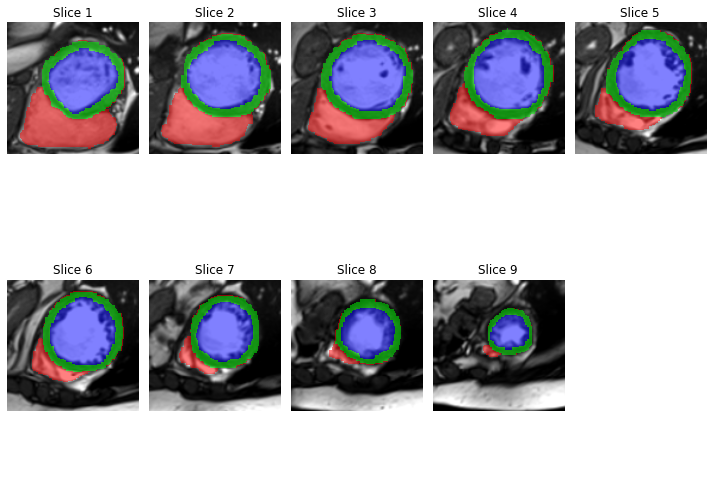

In [13]:
# visualize example after preprocessing
util.visualize_3D({"image": train_X[:9,0].permute(1,2,0),
                   "label": train_Y[:9,0].permute(1,2,0)})

## Prepare dataset and dataloader

In [14]:
TRAIN_RATIO = 0.7
BATCH_SIZE = 64
BATCH_SIZE_VAL = 64

In [15]:
# split train and validation
from sklearn.model_selection import train_test_split

train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, train_size=TRAIN_RATIO)

In [17]:
train_dict = [{"image":train_X[i], "label":train_Y[i]} for i in range(len(train_X))]

In [ ]:
from monai.transforms import RandFlipd, RandRotated, RandAdjustContrastd

In [ ]:
PROB = 0.2
data_aug = Compose([
    RandFlipd(
        keys=["image", "label"],
        spatial_axis=[0],
        prob=PROB),
    RandFlipd(
        keys=["image", "label"],
        spatial_axis=[1],
        prob=PROB),
    RandRotated(
        keys=["image", "label"],
        range_x=0.25*np.pi, # [-45,45]
        prob=PROB),
    RandAdjustContrastd(
        keys=["image"],
        prob=PROB)])

In [19]:
train_set = Dataset(train_dict, transform=data_aug)
val_set = ArrayDataset(img=val_X, seg=val_Y)
test_set = ArrayDataset(img=test_X, seg=test_Y)

In [20]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE_VAL)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE_VAL)

In [21]:
batch = next(iter(train_loader))
batch['image'].shape, batch['label'].shape

(torch.Size([64, 1, 128, 128]), torch.Size([64, 1, 128, 128]))

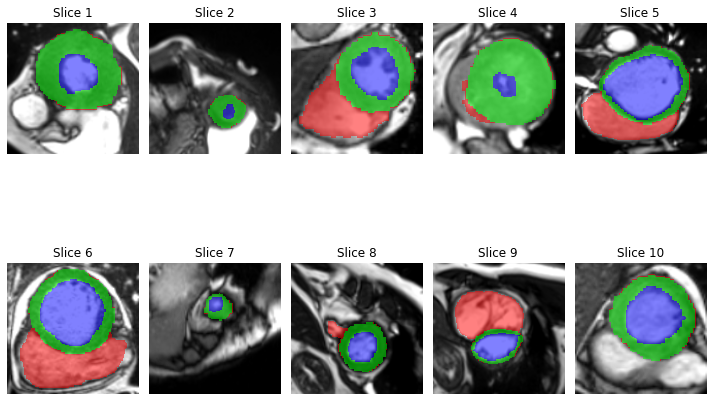

In [22]:
# Visualize the effect of the data augmentation
util.visualize_3D({'image': batch['image'][:10, 0].permute(1,2,0), 'label': batch['label'][:10, 0].permute(1,2,0)})

## Train a U-Net

In [23]:
from unet import UNet

In [24]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 1e-2
EPOCH = 100
SAVE_UNET_PATH = 'saved_models/best_unet_aug.pt'

In [25]:
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

In [26]:
# define model, loss function and optimizer
model = UNet(n_channels=1, n_classes=4).to(DEVICE)
print(model)

# Compute both Dice loss and Cross Entropy Loss, and return the weighted sum of these two losses
loss_function = monai.losses.DiceCELoss(softmax=True, to_onehot_y=True,
                                        lambda_dice=1, lambda_ce=0.1)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [27]:
def compute_eval_loss(model, val_loader):
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_data in val_loader:
            inputs = batch_data[0]
            labels = batch_data[1]

            outputs = model(inputs.to(DEVICE))
            loss = loss_function(outputs, labels.to(DEVICE))

            # print(loss.item())
            epoch_val_loss += loss.item()

    return epoch_val_loss / len(val_loader)

In [31]:
# train model
model.train()

training_losses = []
val_losses = []

min_val_loss = np.inf
best_epoch = 0

for epoch in range(EPOCH):
    epoch_loss = 0

    for batch_data in train_loader:
        inputs = batch_data['image'].to(DEVICE)
        labels = batch_data['label'].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    training_loss = epoch_loss / len(train_loader)
    training_losses.append(training_loss)

    # compute loss on validation set
    val_loss = compute_eval_loss(model, val_loader)
    val_losses.append(val_loss)

    print(f'\nepoch {epoch}/{EPOCH} training loss: {training_loss} validation loss: {val_loss}')



    # if minimum validation loss, save model
    if val_loss < min_val_loss:
        torch.save(model.state_dict(), SAVE_UNET_PATH)
        print('New minimum validation loss')
        min_val_loss = val_loss
        best_epoch = epoch
    else:
        print('No improvement on validation loss')



epoch 0/100 training loss: 0.6431743910438136 validation loss: 0.41433390229940414
New minimum validation loss

epoch 1/100 training loss: 0.4318518073935258 validation loss: 0.3674408234655857
New minimum validation loss

epoch 2/100 training loss: 0.39197189086361933 validation loss: 0.32871901616454124
New minimum validation loss

epoch 3/100 training loss: 0.357957135689886 validation loss: 0.2921519838273525
New minimum validation loss

epoch 4/100 training loss: 0.32662737996954666 validation loss: 0.2715082187205553
New minimum validation loss

epoch 5/100 training loss: 0.30971690071256536 validation loss: 0.25449488312005997
New minimum validation loss

epoch 6/100 training loss: 0.2859915040041271 validation loss: 0.24809094332158566
New minimum validation loss

epoch 7/100 training loss: 0.2720451660846409 validation loss: 0.2251395806670189
New minimum validation loss

epoch 8/100 training loss: 0.26543540154632767 validation loss: 0.22946269623935223
No improvement on val

In [32]:
# load model from checkpoints
print(f'Best validation error {min_val_loss:.4f} is achieved at epoch{best_epoch}')

Best validation error 0.1435 is achieved at epoch87


In [33]:
# SAVE_UNET_PATH = 'saved_models/unet_bbox_crop.pt'
model.load_state_dict(torch.load(SAVE_UNET_PATH, map_location=torch.device('cpu')))
print(f'Weights loaded from {SAVE_UNET_PATH}')

Weights loaded from saved_models/best_unet_aug.pt


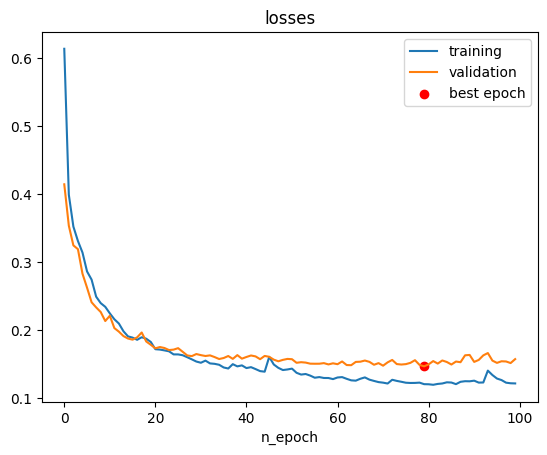

In [ ]:
plt.plot(training_losses, label='training')
plt.plot(val_losses, label='validation')
plt.scatter([best_epoch], [val_losses[best_epoch]], label='best epoch', color='r')
plt.title('losses')
plt.xlabel('n_epoch')
# plt.savefig(os.path.join(base_path,'images/train_loss.png'))
plt.legend()
plt.show()

## Performance on test set

In [34]:
postprocess = monai.transforms.Compose([
    monai.transforms.AsDiscrete(argmax=True, to_onehot=4, dim=1),
    monai.transforms.KeepLargestConnectedComponent(applied_labels=(1, 2, 3), independent=False, connectivity=None)
    # TODO: more postprocess
])

In [35]:
model.eval()

dscs_list = []

dice_metric = monai.metrics.DiceMetric()
hd_metric = monai.metrics.HausdorffDistanceMetric()

for i, test_batch in enumerate(test_loader):

    test_input = test_batch[0]
    with torch.no_grad():
        outputs_test = model(test_input.to(DEVICE))

    outputs_test = postprocess(outputs_test) # (BS, 4, H, W) a 0-1 mask for 4 classes

    y_pred = outputs_test.cpu()
    y_gt = monai.networks.utils.one_hot(test_batch[1],dim=1,num_classes=4)

    dsc = dice_metric(y_pred[:, 1:, :, :], y_gt[:, 1:, :, :]) # exclude background (BS, 3)
    dscs_list.append(dsc)

    # hd = hd_metric(y_pred, y_gt)
    # hds[i] = np.nanmean(hd.numpy(),axis=0)

dscs = np.concatenate(dscs_list, axis=0)
dscs.shape

(857, 3)

In [36]:
dscs

array([[       nan, 0.82900816, 0.96506023],
       [0.96358   , 0.8983988 , 0.9769927 ],
       [0.9673227 , 0.9052754 , 0.9834536 ],
       ...,
       [0.81304896, 0.9283192 , 0.91800505],
       [0.7788945 , 0.93536896, 0.9       ],
       [       nan, 0.73722625, 0.25531915]], dtype=float32)

In [37]:
print(f'average DICE score on test set: {np.nanmean(dscs):.3f}')
print(f'average DICE score on test set for class 1: {np.nanmean(dscs[:,0]):.3f}')
print(f'average DICE score on test set for class 2: {np.nanmean(dscs[:,1]):.3f}')
print(f'average DICE score on test set for class 3: {np.nanmean(dscs[:,2]):.3f}')

average DICE score on test set: 0.896
average DICE score on test set for class 1: 0.885
average DICE score on test set for class 2: 0.874
average DICE score on test set for class 3: 0.926


In [38]:
# smallest (resp. biggest) DICE metrics - worst (resp. best) performance
dsc_means = np.nanmean(dscs, axis=1)
sorted_indices = np.argsort(dsc_means)
worst_indices = sorted_indices[:10]
best_indices = sorted_indices[-10:][::-1]
worst_indices, best_indices

(array([489, 691, 320, 481, 801, 518, 528, 707, 785, 367]),
 array([570, 693, 627, 643, 151, 120, 692, 644, 143, 809]))

In [39]:
worst_batch = (test_X[worst_indices.copy()], test_Y[worst_indices.copy()])
best_batch = (test_X[best_indices.copy()], test_Y[best_indices.copy()])

In [40]:
def predict_label(test_batch, visualize=False):
    test_input = test_batch[0]

    with torch.no_grad():
        outputs_test = model(test_input.to(DEVICE))

    outputs_test = postprocess(outputs_test) # (BS, 4, H, W) a 0-1 mask for 4 classes

    y_pred = outputs_test.cpu()
    y_gt = monai.networks.utils.one_hot(test_batch[1],dim=1,num_classes=4)


    if visualize:
        label_pred = torch.argmax(outputs_test, dim=1).cpu()
        label_gt = test_batch[1].squeeze()

        print('ground truth')
        util.visualize_3D({"image": test_input[:,0].permute(1,2,0),
                           "label": label_gt[:].permute(1,2,0)})

        print('prediction')
        util.visualize_3D({"image": test_input[:,0].permute(1,2,0),
                           "label": label_pred[:].permute(1,2,0)})


ground truth


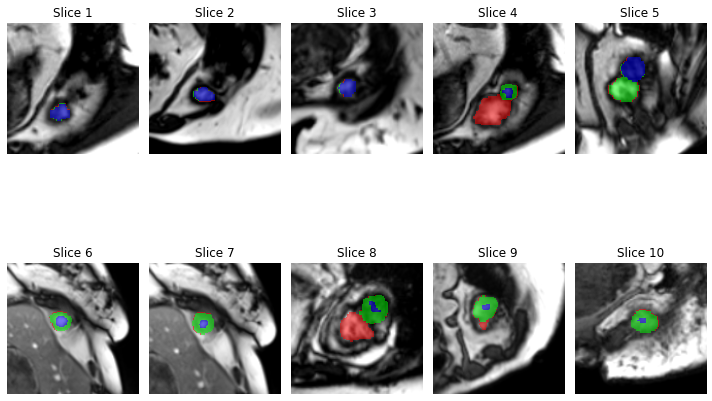

prediction


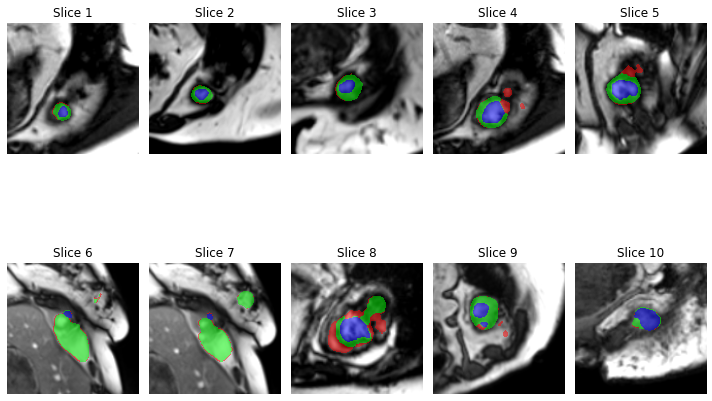

In [41]:
predict_label(worst_batch, visualize=True)

ground truth


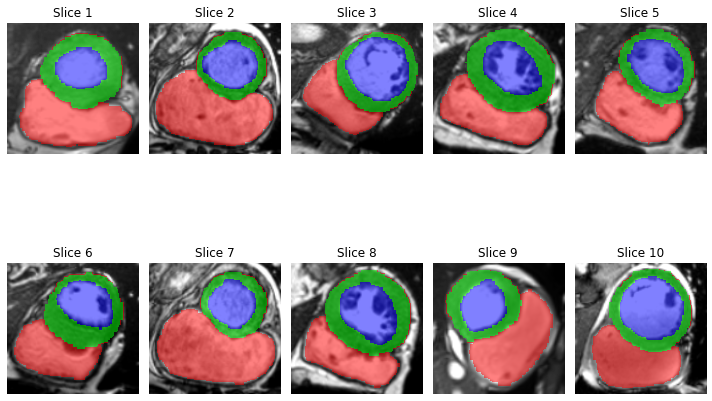

prediction


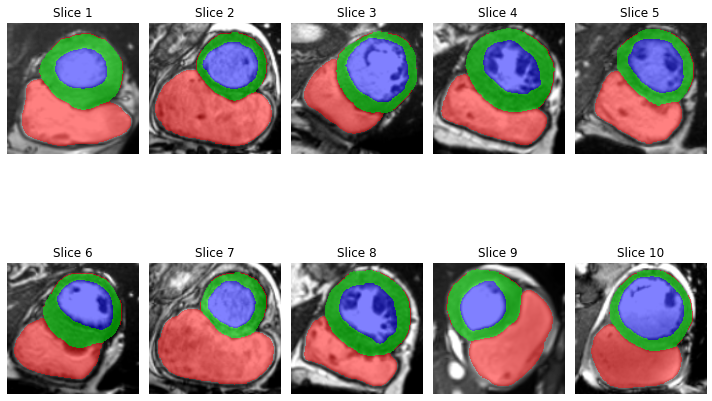

In [42]:
predict_label(best_batch, visualize=True)

### Preprocessing for 3D segmentation

In [ ]:
train_transforms = Compose([
     LoadImaged(keys=["image", "label"]),
     EnsureChannelFirstd(keys=["image", "label"]),
     Orientationd(keys=["image", "label"], axcodes="RAS"),
     Spacingd(
        keys=["image", "label"],
        pixdim=[1.25, 1.25, 10],
        mode=("bilinear", "nearest")),
     CropForegroundSquared(keys=["image", "label"], source_key="label", min_margin=5),
     ScaleIntensityRangePercentilesd(
        keys=["image"],
        lower=5,
        upper=95,
        b_min=0.0,
        b_max=1.0,
        clip=True),
     Resized(
        keys=["image", "label"],
        spatial_size=(128,128,8),
        mode=("trilinear", "nearest")),
     # RandFlipd(
     #    keys=["image", "label"],
     #    spatial_axis=[0],
     #    prob=0.2),
     # RandFlipd(
     #    keys=["image", "label"],
     #    spatial_axis=[1],
     #    prob=0.2),
     # RandFlipd(
     #    keys=["image", "label"],
     #    spatial_axis=[2],
     #    prob=0.2),
])

test_transforms = Compose(
    [LoadImaged(keys=["image", "label"]),
     EnsureChannelFirstd(keys=["image", "label"]),
     Orientationd(keys=["image", "label"], axcodes="RAS"),
     Spacingd(
        keys=["image", "label"],
        pixdim=[1.25, 1.25, 10],
        mode=("bilinear", "nearest")),
     CropForegroundSquared(keys=["image", "label"], source_key="label", min_margin=5),
     ScaleIntensityRangePercentilesd(
        keys=["image"],
        lower=5,
        upper=95,
        b_min=0.0,
        b_max=1.0,
        clip=True),
     Resized(
        keys=["image", "label"],
        spatial_size=(128,128,8),
        mode=("trilinear", "nearest"))])

In [ ]:
np.random.shuffle(train_dicts)
train_len = int(len(train_dicts)*0.7)
train_dicts, val_dicts = train_dicts[:train_len], train_dicts[train_len:]

In [ ]:
train_set = Dataset(data=train_dicts, transform=train_transforms)
val_set = Dataset(data=val_dicts, transform=test_transforms)
test_set = Dataset(data=test_dicts, transform=test_transforms)

In [ ]:
train_loader = DataLoader(train_set, batch_size=8)